In [1]:
variants = ['AlexNet', 'ResNet50']
SURNAME = 'Богатырева'
print(variants[hash(SURNAME.lower()) % len(variants) ])

AlexNet


In [1]:
%matplotlib inline

import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch
from torch.autograd import Variable
import numpy as np
from PIL import Image
import copy

from IPython.display import display

In [2]:
CUDA_DEVICE = 3
mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]
trans = transforms.Compose([
            transforms.Normalize(mean, std)
        ])

postpa = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0],
                             std=[1/255, 1/255, 1/255]),
    ])
postpb = transforms.Compose([transforms.ToPILImage()])    
    
def numpy2image(img_numpy, gr=0):
    if img_numpy.dtype == np.dtype('float64'): #нужно домножить на 255 и поменять тип
        img_numpy = (img_numpy*255).astype('uint8')
        img_numpy += gr
    return Image.fromarray(img_numpy)

def decay_lr(optimizer, factor):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= factor

# L2 decay регуляризация 
def l2_decay(img, theta):
    img.data *= (1-theta)       
        
def postp(tensor):
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    return t


In [3]:
import copy
from collections import OrderedDict

class FeaturesExtractor(nn.Module):
    
        def __init__(self, input_features, layer_idx=12): # 1, 4, 7, 9, 12
            
            super(FeaturesExtractor, self).__init__()
            mods = OrderedDict()

            for i in range(0, layer_idx):
                mods[str(i)] = copy.deepcopy(input_features[i])
                
            self.features = nn.Sequential(mods)
            
            #for idx, module in self.features._modules.items():
            #    if module.__class__.__name__ is 'ReLU':
            #        self.features._modules[idx] = GuidedBackpropReLU()            
            
        def forward(self, input):
            return self.features(input)

True


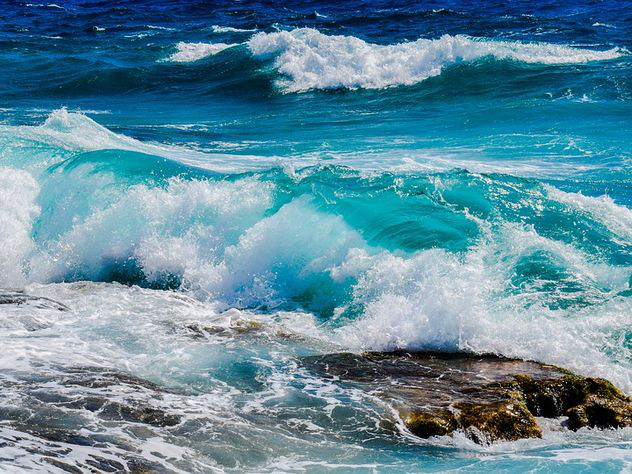

In [4]:
img_deep_dream =  np.asarray(Image.open('./img/sea.jpeg')) / 255.0
print(img_deep_dream.dtype == np.dtype('float64'))
numpy2image(img_deep_dream)

In [5]:
net = models.alexnet(pretrained=True)
net.eval()
#print(net.features[10].out_channels)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096,

In [18]:
img = copy.deepcopy(img_deep_dream)

n_iter = 100
layer_idx = 12

lr = 1e-4
decay_iter = n_iter
decay_factor = 1e-1

max_jitter = 32
step_size = 0    
TRACE_ITER = 5

Iter 0

( 0 , 0 ,.,.) = 
   -1.3687   -2.1430   -6.1008  ...     0.6544   -0.0258   -0.3123
   -0.3809   -1.1037   -4.7869  ...     0.5654    1.1443    0.7168
   -3.2390   -2.6842   -2.0544  ...     1.0763    1.5423    1.5863
              ...                ⋱                ...             
   -0.7730   -0.5675   -0.4419  ...     0.0935   -0.0049    0.0421
   -1.1682   -1.1402   -1.0671  ...     0.0915   -0.0487    0.1198
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000

( 0 , 1 ,.,.) = 
    3.1984    1.9592   -3.0011  ...    -0.4166   -0.8846   -1.2331
    4.3006    3.6145   -1.4804  ...    -0.7223    0.3953    0.0569
    2.1804    2.9478    3.3563  ...    -0.0714    0.6927    1.0714
              ...                ⋱                ...             
    0.0308    0.2431    0.4180  ...     0.1217    0.0447    0.1314
    0.8512    1.2429    1.4257  ...     0.0291   -0.0594    0.1030
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000

( 0 , 2 ,.,.) = 
 

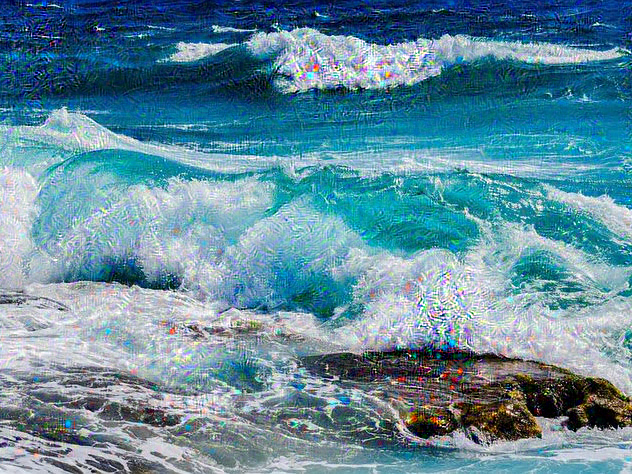


Iter 5

( 0 , 0 ,.,.) = 
    1.5820    1.9892   -0.7388  ...    -0.0124   -0.5452   -0.7110
    0.0983    1.7322    0.4654  ...     0.0074   -0.6710   -0.5499
   -0.4604    1.6826    5.1011  ...     1.3407   -0.3909   -0.8615
              ...                ⋱                ...             
    0.4338    1.2248   -0.4708  ...    -0.0915   -0.0436    0.1051
   -0.6460    0.6774   -0.2187  ...     0.0013    0.0111    0.1420
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000

( 0 , 1 ,.,.) = 
    1.3112    0.2413   -3.4781  ...    -0.9951   -2.1686   -1.9004
    1.6165    1.3547   -0.5059  ...    -1.3369   -2.1353   -1.3378
    3.3042    3.7136    5.9349  ...    -0.1557   -1.3695   -0.7066
              ...                ⋱                ...             
    0.3226    1.0129   -0.6513  ...     0.0818    0.1380    0.1959
   -0.5297    0.8245   -0.1108  ...    -0.2542   -0.1965   -0.0792
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000

( 0 , 2 ,.,.) = 


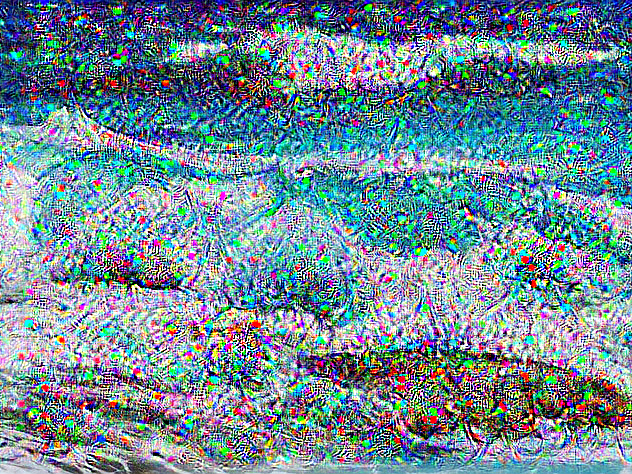

KeyboardInterrupt: 

In [19]:
buff_net = FeaturesExtractor(net.features, layer_idx)

for iter_id in range(n_iter):

    shift_x, shift_y = np.random.randint( -max_jitter, max_jitter + 1, 2)
    img = np.roll(np.roll(img, shift_x, -1), shift_y, -2)

    in_img = torch.from_numpy(img).transpose(2,1).transpose(1,0).float()
    in_img = Variable(trans(in_img).unsqueeze(0), requires_grad=True) # тут нам нужен будет градиент
    #print(in_img)
    
    #forward до нужного слоя
    optimizer = torch.optim.SGD([in_img], lr=lr)
    optimizer.zero_grad()
    out = buff_net.forward(in_img)
    #backward dx=x - погуглить, как сделать такое равенство
    #loss = -torch.sum((out.squeeze(0))**2, dim=0).mean()
    #loss = torch.sum(out.squeeze(0), dim=0).mean()
    #loss = torch.autograd.grad(outputs=out, inputs=in_img, grad_outputs=out, retain_graph=True)[0]
    
    out.backward(gradient=out, retain_graph=True)
    #loss.backward()
    optimizer.step()
    
    if n_iter%decay_iter == 0:
        decay_lr(optimizer, decay_factor)

    grad = in_img.grad.data
    grad = grad[0, :, :, :]
    grad =  grad.transpose(0,1).transpose(1,2).numpy() #превращаем градиент в numpy 
    
    #обновление картинки img - самим
    
    img = img + 1e-3*grad
    img = np.roll(np.roll(img, -shift_x, -1), -shift_y, -2)
    img = np.clip(img, 0, 1)
    
    if iter_id % TRACE_ITER == 0:
        print("Iter %d" % iter_id)
        #print("Loss: ", loss.data)
        print(in_img.grad.data)
        display(numpy2image(img))
        print()
        
print("Iter %d" % iter_id)
display(numpy2image(img))
print()

Черновик

In [14]:
img = copy.deepcopy(img_deep_dream)

max_jitter = 32
step_size = 0    
TRACE_ITER = 5

shift_x, shift_y = np.random.randint( -max_jitter, max_jitter + 1, 2)
img = np.roll(np.roll(img, shift_x, -1), shift_y, -2)

in_img = torch.from_numpy(img).transpose(2,1).transpose(1,0).float()
in_img = Variable(trans(in_img).unsqueeze(0), requires_grad=True) # тут нам нужен будет градиент
    
buff_net = FeaturesExtractor(net.features, 12)
optimizer = torch.optim.SGD([in_img], lr=lr, momentum=0)
optimizer.zero_grad()
out = buff_net.forward(in_img)
#loss0 = -torch.sum(out[0].data**2, dim=0)
#loss = (-torch.sum((out.squeeze(0))**2, dim=0)).mean()
loss = torch.autograd.grad(outputs=out, inputs=in_img, grad_outputs=out,
                              create_graph=True, retain_graph=True)

#loss = -out
#loss.backward()
#optimizer.step()
# print(net.features[(8)].weight.size())

In [29]:
grad = in_img.grad.data
grad = grad[0, :, :, :]
grad =  grad.transpose(0,1).transpose(1,2).numpy() 

In [37]:
b = Variable(out.data)
out.grad = b
print(out.grad)

Variable containing:
( 0 , 0 ,.,.) = 
   8.0886   0.2144   6.5268  ...    0.0000   0.0000   1.9784
   0.0537   0.0000   0.2617  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
            ...               ⋱              ...            
   3.9556   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   1.0931   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000

( 0 , 1 ,.,.) = 
   5.9561   2.3383   0.0000  ...    6.9474   3.1350  10.5024
   8.5824   0.0000   0.0000  ...    9.4871   4.8907   5.7033
  10.9495   1.8888   0.0000  ...    5.1895   0.4037   2.8720
            ...               ⋱              ...            
   2.1945   5.6797   8.9467  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   4.0158  ...    0.0000   0.0000   0.0000
   3.3601   0.0000   0.6711  ...    0.0000   0.0000   0.0000

( 0 , 2 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000  

In [76]:
loss = torch.sum((out.squeeze(0))**2, dim=0).mean()

In [77]:
#print(torch.max(out[0, 254], 0))
print((out*out).size())
#print(grad.shape, img.shape)
#print(out.mean())
print(loss)
#print(loss0)
#print(loss1)
#print((torch.sum(out**2)).data.numpy())
#print(torch.mean(out**2))

torch.Size([1, 256, 28, 38])
Variable containing:
 153.7738
[torch.FloatTensor of size 1]

